<a href="https://colab.research.google.com/github/rameshavinash94/Customer_Segmentation_Clustering/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation using RFM and Clustering**

**A project of the Olist store Ecommerce Analysis**

**Using RFM Analysis and Clustering techniques like K-Means,AgglomerativeClustering to Investigate Customer Segmentation**



**Our Business Problem:**

*Dividing customers into groups for the purpose of targeting advertisements or promotions (based on purchasing patterns,purchase history)*

**NOTE:** The Data is Highely Skewed So, results won't be perfectly accurate.

#### **IMPORTING LIBRARIES**

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import plotly.express as px
from sklearn.cluster import AgglomerativeClustering

#### **IMPORTING DATASET FROM KAGGLE AND LOAD IN THE NOTEBOOK**

In [2]:
#setting up the colab for kaggle dataset
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


**downloading dataset from kaggle**

In [3]:
! kaggle datasets download olistbr/brazilian-ecommerce

brazilian-ecommerce.zip: Skipping, found more recently modified local copy (use --force to force download)


In [4]:
#unzip the datasets to look at the files sepearetely as we  won't require all the files for customer segmentation
! unzip /content/brazilian-ecommerce.zip

Archive:  /content/brazilian-ecommerce.zip
replace olist_customers_dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: All
  inflating: olist_customers_dataset.csv  
  inflating: olist_geolocation_dataset.csv  
  inflating: olist_order_items_dataset.csv  
  inflating: olist_order_payments_dataset.csv  
  inflating: olist_order_reviews_dataset.csv  
  inflating: olist_orders_dataset.csv  
  inflating: olist_products_dataset.csv  
  inflating: olist_sellers_dataset.csv  
  inflating: product_category_name_translation.csv  


**Load the datasets**

In [5]:
customers = pd.read_csv('olist_customers_dataset.csv')
order_items = pd.read_csv('olist_order_items_dataset.csv')
order_payment= pd.read_csv('olist_order_payments_dataset.csv')
geolocation = pd.read_csv('olist_geolocation_dataset.csv')
order_reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
product_category_name = pd.read_csv('product_category_name_translation.csv')

The ER/Data Modeling Structure of the Datasource
<div>
<img src='https://i.imgur.com/HRhd2Y0.png'>
</div>


*We won't require all the above datasets for our current business usecase for customer segmentation, so selectiong on the necessary files and carryon the EDA and data wrangling on the datasets.*

#### **DATA INTEGRATION AND FEATURE EXTRACTION**

Now Lets merge the required datasets into a single data source for analysis.

In [6]:
#merge all seller info with all order info
seller_orders=pd.merge(order_items,sellers, how='inner')
df_order = pd.merge(orders, seller_orders, how='inner')
final_order_df = pd.merge(df_order, order_payment,how='inner')

In [7]:
#merge all products
df_products = pd.merge(product_category_name,products, how='inner')
products_order = pd.merge(final_order_df,df_products)

In [8]:
#merged the above dataframe with customers to get final dataframe
customer_orders = pd.merge(products_order, customers,how='inner')

In [9]:
#create new df with final_df as name for understanding
final_df=customer_orders

In [10]:
#data shape
final_df.shape

(115878, 34)

In [11]:
#list of columns
final_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date',
       'price', 'freight_value', 'seller_zip_code_prefix', 'seller_city',
       'seller_state', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'product_category_name',
       'product_category_name_english', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state'],
      dtype='object')

In [12]:
#view the dataframe
final_df

order_id  ... customer_state
0       e481f51cbdc54678b7cc49136f2d6af7  ...             SP
1       e481f51cbdc54678b7cc49136f2d6af7  ...             SP
2       e481f51cbdc54678b7cc49136f2d6af7  ...             SP
3       128e10d95713541c87cd1a2e48201934  ...             SP
4       0e7e841ddf8f8f2de2bad69267ecfbcf  ...             SP
...                                  ...  ...            ...
115873  e8fd20068b9f7e6ec07068bb7537f781  ...             SP
115874  e8fd20068b9f7e6ec07068bb7537f781  ...             SP
115875  cfa78b997e329a5295b4ee6972c02979  ...             PR
115876  9c5dedf39a927c1b2549525ed64a053c  ...             SP
115877  66dea50a8b16d9b4dee7af250b4be1a5  ...             PR

[115878 rows x 34 columns]

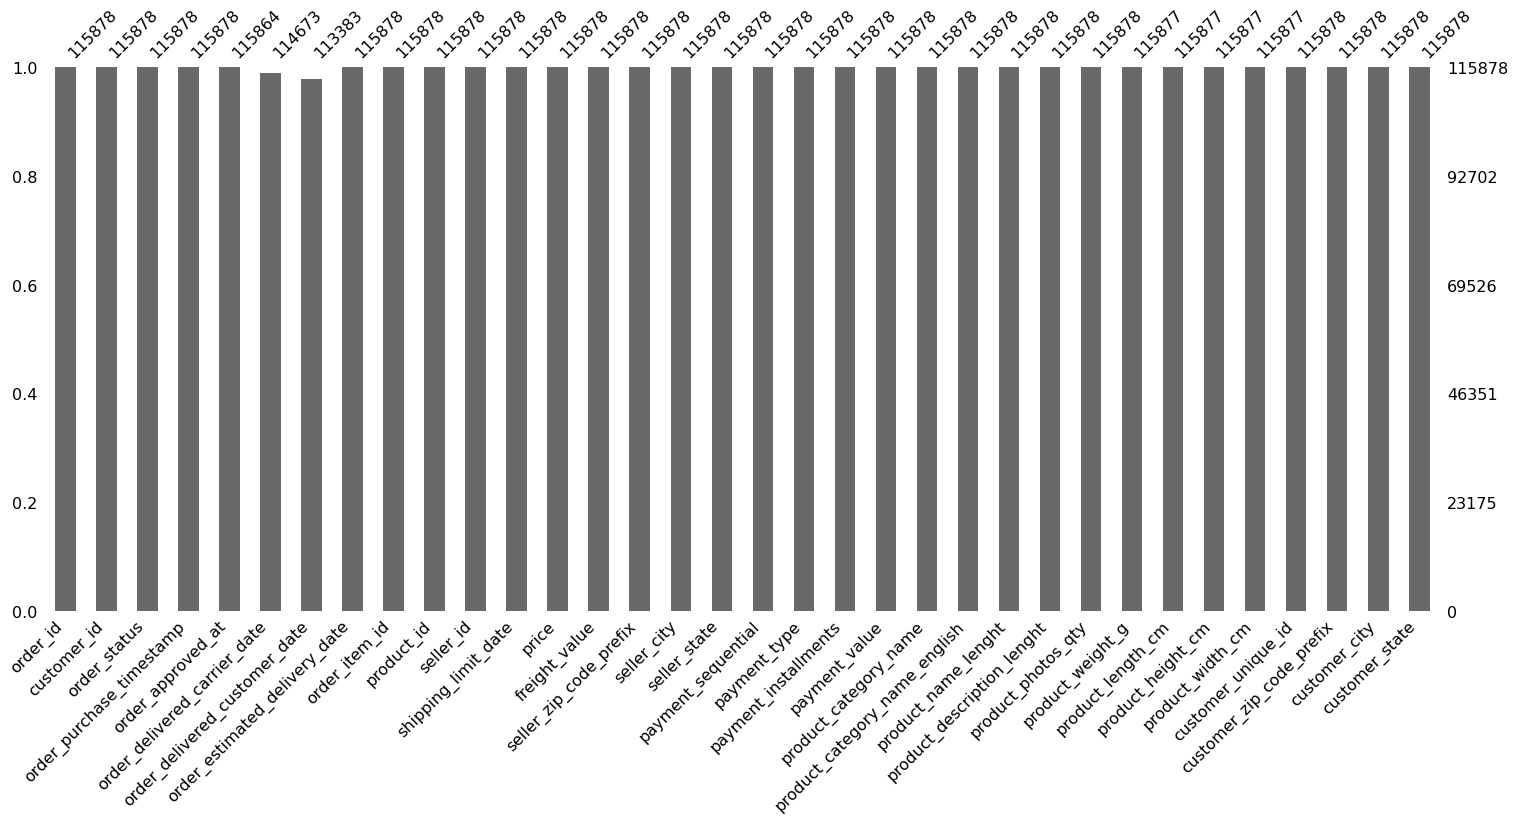

In [13]:
#plotting data for easier understanding
#missingno is a great library for visualizing missing data.
msno.bar(final_df)

*From the Above, we can't see  much missing values in the required features for our usecase. We are going to extract and filter only the required features and continue further processing*

In [14]:
# print all the existing status of the orders
final_df['order_status'].unique()

array(['delivered', 'shipped', 'invoiced', 'canceled', 'processing',
       'unavailable', 'approved'], dtype=object)

In [15]:
#for our analysis we are checking only delivered products
delivered = final_df[final_df['order_status']=='delivered']

**Since our business problem is Customer Segmentation based on RMF analysis, we are going to use only few features for this usecase. Dropping unnecessary features**

In [16]:
#filtering only necessary features for the problem statement: customer segmentation 
filtered_df = delivered.drop(columns=['order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date','shipping_limit_date',
       'product_name_lenght','seller_zip_code_prefix','seller_city',
       'seller_state','payment_installments','payment_sequential', 'payment_type','payment_value',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'customer_unique_id','product_category_name'
       ])

In [17]:
# final list of columns 
filtered_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_item_id', 'product_id', 'seller_id', 'price', 'freight_value',
       'product_category_name_english', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object')

In [18]:
#removing duplicates since customer made payment in multiple payment sequence for a single order(credit card,voucher,cash,etc..)
customer_filtered = filtered_df.drop_duplicates()

In [19]:
#finding total value of the order = price + freight_value
customer_filtered['total_order_value']=customer_filtered['price']+customer_filtered['freight_value']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [20]:
#drop price and freight value post combining them into a new column
customer_filtered.drop(columns=['price','freight_value'],inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


*To comprehend the customer's behavior RFM metrics are important because frequency and monetary value influence a customer's lifetime value, and recency influences retention, which is a measure of engagement.
Here, the frequency of customers is calculated by counting each customer's order id; the higher the count, the more frequently the customer purchases from the store.*

**FREQUENCY**

In [21]:
#lets find the frequency of customer orders
Customer_order_frequency = customer_filtered.groupby('customer_id')['order_id'].count().to_frame()
Customer_order_frequency.rename(columns={'order_id':'Frequency'},inplace=True)

In [22]:
#finding the customer order frequency
Customer_order_frequency.sort_values('Frequency',ascending=False)

Frequency
customer_id                                
fc3d1daec319d62d49bfb5e1f83123e9         21
be1b70680b9f9694d8c70f41fa3dc92b         20
bd5d39761aa56689a265d95d8d32b8be         20
adb32467ecc74b53576d9d13a5a55891         15
10de381f8a8d23fff822753305f71cae         15
...                                     ...
5a158dfc1554dd2b4fe7f3c2581993bd          1
5a1523d32a6d1b323a05895f5164655d          1
5a141d03e70c4c36cfcce2d07cc42f72          1
5a1378910e540a78b55df6f430a14cea          1
7fedd1fd0e93898a67a4ffa570b50497          1

[95126 rows x 1 columns]

**RECENCY**

Calculating Recency, here we are calculating recency by subtracting the very recent date with the last transaction date of the customers.

In [23]:
#sort by order_purchase_timestamp to view the recent purchase made.
customer_filtered.sort_values('order_purchase_timestamp',ascending=False).head()

order_id  ... total_order_value
31060   35a972d7f8436f405b56e36add1a7140  ...             93.75
108061  03ef5dedbe7492bdae72eec50764c43f  ...             33.23
47792   168626408cb32af0ffaf76711caae1dc  ...             61.29
63527   0b223d92c27432930dfe407c6aea3041  ...            255.48
63526   0b223d92c27432930dfe407c6aea3041  ...            255.48

[5 rows x 12 columns]

*Since, the **last purchase date is '2018-08-29'**, lets consider **current date as the  '2018-08-30'** for the purpose of analysis*

In [24]:
#convert timestamp to date
customer_filtered['order_purchase_timestamp'] = pd.to_datetime(customer_filtered['order_purchase_timestamp']).dt.date

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [25]:
#rename column to order_date
customer_filtered.rename(columns={'order_purchase_timestamp':'order_date'},inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [26]:
#mention current_Date as recent date+1 ('2018-08-30') for the purpose of analysis
current_date=max(customer_filtered['order_date'])+pd.Timedelta(days=1)

#Recent days calculation from order_date
customer_filtered['Recently']=current_date-customer_filtered['order_date']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [27]:
#create new df for uderstanding
Recently=customer_filtered

In [28]:
#group by customers_id nased on the recent order date
Recently=customer_filtered.groupby('customer_id')['Recently'].min().to_frame()
Recently['Recently'] = Recently['Recently'].dt.days.astype('int')

In [29]:
Recently

Recently
customer_id                               
00012a2ce6f8dcda20d059ce98491703       289
000161a058600d5901f007fab4c27140       410
0001fd6190edaaf884bcaf3d49edf079       548
0002414f95344307404f0ace7a26f1d5       379
000379cdec625522490c315e70c7a9fb       150
...                                    ...
fffcb937e9dd47a13f05ecb8290f4d3e       166
fffecc9f79fd8c764f843e9951b11341       154
fffeda5b6d849fbd39689bb92087f431       100
ffff42319e9b2d713724ae527742af25        78
ffffa3172527f765de70084a7e53aae8       362

[95126 rows x 1 columns]

**MONETARY**

Now, Lets calculate the monetary by summing up all the amounts of the customer.

In [30]:
#calculate monetary for each customer
Monetary = customer_filtered.groupby('customer_id')['total_order_value'].sum().to_frame()
Monetary.rename(columns={'total_order_value':'MonetaryValue'},inplace=True)

**Now, Lets merge Frequency, Monetary, Recently in a single Dataframe for Customer Segmentation**

In [31]:
#merging monetary and frequency
Monetary_frequency = pd.merge(Monetary,Customer_order_frequency,how='inner',left_index=True,right_index=True)

In [32]:
Monetary_frequency

MonetaryValue  Frequency
customer_id                                               
00012a2ce6f8dcda20d059ce98491703         114.74          1
000161a058600d5901f007fab4c27140          67.41          1
0001fd6190edaaf884bcaf3d49edf079         195.42          1
0002414f95344307404f0ace7a26f1d5         179.35          1
000379cdec625522490c315e70c7a9fb         107.01          1
...                                         ...        ...
fffcb937e9dd47a13f05ecb8290f4d3e          91.91          1
fffecc9f79fd8c764f843e9951b11341          81.36          1
fffeda5b6d849fbd39689bb92087f431          63.13          1
ffff42319e9b2d713724ae527742af25         214.13          1
ffffa3172527f765de70084a7e53aae8          45.50          2

[95126 rows x 2 columns]

In [33]:
#finally merge Monetary_frequency with Recently to get RMF for each customer
Customer_RMF= pd.merge(Monetary_frequency,Recently,how='inner',left_index=True,right_index=True)

In [34]:
Customer_RMF

MonetaryValue  Frequency  Recently
customer_id                                                         
00012a2ce6f8dcda20d059ce98491703         114.74          1       289
000161a058600d5901f007fab4c27140          67.41          1       410
0001fd6190edaaf884bcaf3d49edf079         195.42          1       548
0002414f95344307404f0ace7a26f1d5         179.35          1       379
000379cdec625522490c315e70c7a9fb         107.01          1       150
...                                         ...        ...       ...
fffcb937e9dd47a13f05ecb8290f4d3e          91.91          1       166
fffecc9f79fd8c764f843e9951b11341          81.36          1       154
fffeda5b6d849fbd39689bb92087f431          63.13          1       100
ffff42319e9b2d713724ae527742af25         214.13          1        78
ffffa3172527f765de70084a7e53aae8          45.50          2       362

[95126 rows x 3 columns]

In [35]:
#describe the df columns
Customer_RMF.describe()

MonetaryValue     Frequency      Recently
count   95126.000000  95126.000000  95126.000000
mean      159.959175      1.142012    239.945294
std       218.700486      0.538617    152.824978
min         9.590000      1.000000      1.000000
25%        61.980000      1.000000    116.000000
50%       105.160000      1.000000    221.000000
75%       176.810000      1.000000    350.000000
max     13664.080000     21.000000    696.000000

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

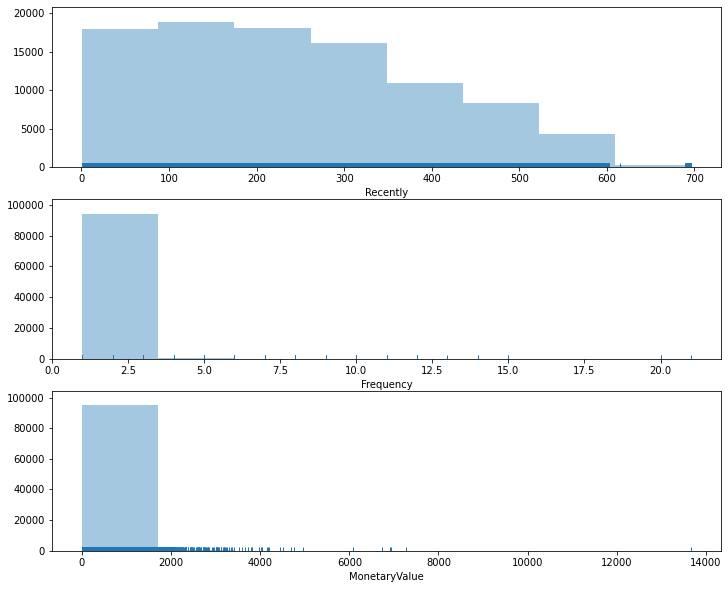

In [36]:
# Plot RFM distributions
plt.figure(figsize=(12,10))
# Plot distribution of R
plt.subplot(3, 1, 1); sns.distplot(Customer_RMF['Recently'],bins=8,kde=False,rug=True)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(Customer_RMF['Frequency'],bins=8,kde=False,rug=True)
# Plot distribution of M
plt.subplot(3, 1, 3); sns.distplot(Customer_RMF['MonetaryValue'],bins=8,kde=False,rug=True)
# Show the plot
plt.show()

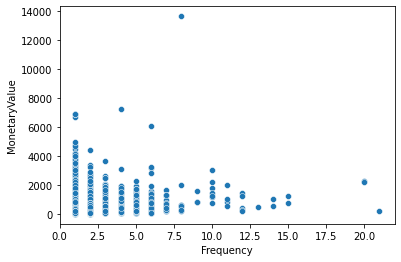

In [37]:
#lets plot Frequency vs MonetaryValue to understanding the behavior of the customer
sns.scatterplot(x='Frequency',y='MonetaryValue',data=Customer_RMF)

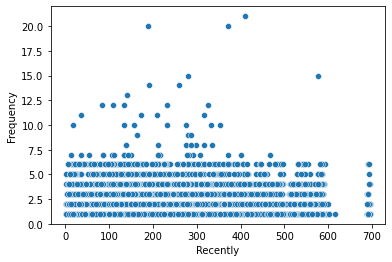

In [38]:
#lets plot recently vs frequency to understanding the behavior of the customer
sns.scatterplot(x='Recently',y='Frequency',data=Customer_RMF)

**NORMALIZING VALUE PRIOR KMEANS**

In [39]:
#Now lets standadize the scale
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized= scaler.fit_transform(Customer_RMF)

In [40]:
#creating normalized dataframe
Customer_RFM_normalized=pd.DataFrame(normalized)

In [41]:
#rename columns for understanding
Customer_RFM_normalized.rename(columns={0:'MonetaryValue',1:'Frequency',2:'Recently'},inplace=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103: FutureWarning: The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2103

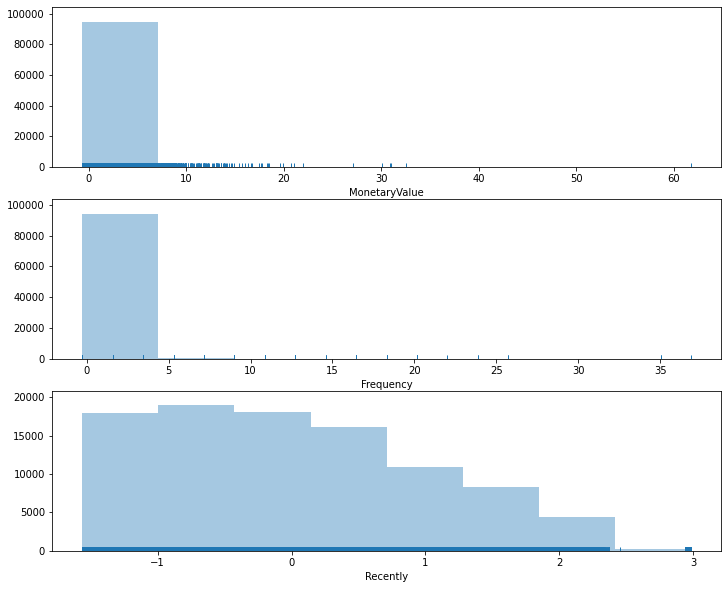

In [42]:
# Plot RFM distributions post normalization
plt.figure(figsize=(12,10))
# Plot distribution of M
plt.subplot(3, 1, 1); sns.distplot(Customer_RFM_normalized['MonetaryValue'],bins=8,kde=False,rug=True)
# Plot distribution of F
plt.subplot(3, 1, 2); sns.distplot(Customer_RFM_normalized['Frequency'],bins=8,kde=False,rug=True)
# Plot distribution of R
plt.subplot(3, 1, 3); sns.distplot(Customer_RFM_normalized['Recently'],bins=8,kde=False,rug=True)
# Show the plot
plt.show()

*From the Above , we can say most of the customers are in the frequency range of 1-5 trasactions in our Store.*

#### **CLUSTERING ON RMF values of Customer to understand Customer Buying Behavior**

**Now Lets Perform Kmeans on the Above Dataset**

**Finding the optimal value of K using Elbow Method**

In [43]:
#finding the optimal value of K using elbow method
Distortion=[]
for x in range(1,10):
  kmeans = KMeans(n_clusters=x,max_iter=50)
  kmeans.fit(Customer_RFM_normalized)
  Distortion.append(kmeans.inertia_)

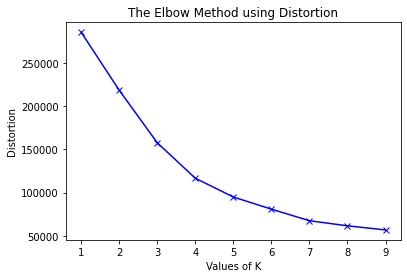

In [44]:
#plot to view the optimal value of K
K = range(1, 10)
plt.plot(K, Distortion, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

From the Figure, We can say the optimal value of K is 4 or 5

**Silhouette And Other Metrics**

In [45]:
print("silhouette_score -", silhouette_score(Customer_RFM_normalized, kmeans.labels_, metric='euclidean'))
print("calinski_harabasz_score -", calinski_harabasz_score(Customer_RFM_normalized, kmeans.labels_))
print("davies_bouldin_score -", davies_bouldin_score(Customer_RFM_normalized, kmeans.labels_))

silhouette_score - 0.4292331033972289
calinski_harabasz_score - 47801.334802397374
davies_bouldin_score - 0.7819576113072991


In [46]:
#perform Kmeans
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(Customer_RFM_normalized)

KMeans(max_iter=50, n_clusters=4)

**3D plot**

In [47]:
#3d plot post Kmeans
fig = px.scatter_3d(Customer_RFM_normalized, x='MonetaryValue', y='Frequency', z='Recently',
              color=kmeans.labels_)
fig.show()

In [48]:
#append the customer name to the normalized df
Customer_RFM_normalized_kmeans=Customer_RFM_normalized.copy()
Customer_RFM_normalized_kmeans.loc[:,'customer_id'] = Customer_RMF.index

In [49]:
#add cluster labels to view which customer belong to which cluster group for analysis
Customer_RFM_normalized_kmeans['Cluster_Category'] = kmeans.labels_

In [50]:
Customer_RFM_normalized_kmeans

MonetaryValue  ...  Cluster_Category
0          -0.206764  ...                 1
1          -0.423180  ...                 1
2           0.162144  ...                 1
3           0.088664  ...                 1
4          -0.242109  ...                 0
...              ...  ...               ...
95121      -0.311154  ...                 0
95122      -0.359394  ...                 0
95123      -0.442750  ...                 0
95124       0.247695  ...                 0
95125      -0.523363  ...                 1

[95126 rows x 5 columns]

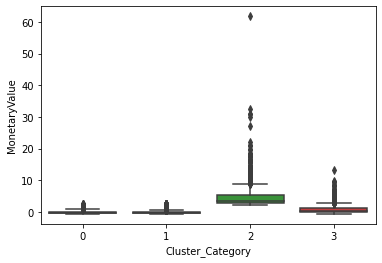

In [51]:
#plot based on Cluster_Category and MonetaryValue
sns.boxplot(x='Cluster_Category',y='MonetaryValue',data=Customer_RFM_normalized_kmeans)

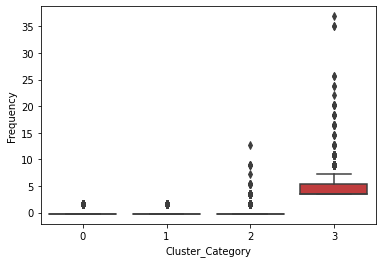

In [52]:
#plot based on Cluster_Category and Frequency
sns.boxplot(x='Cluster_Category',y='Frequency',data=Customer_RFM_normalized_kmeans)

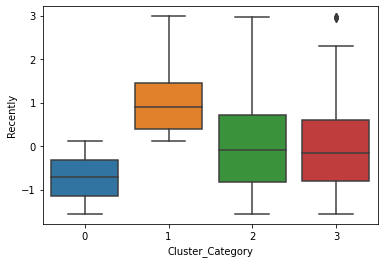

In [53]:
#plot based on Cluster_Category and Recently
sns.boxplot(x='Cluster_Category',y='Recently',data=Customer_RFM_normalized_kmeans)

In [54]:
Customer_RFM_normalized_kmeans.groupby('Cluster_Category')['customer_id'].count()

Cluster_Category
0    51877
1    38761
2     2324
3     2164
Name: customer_id, dtype: int64

<table>
<tr>
<th>Cluster_Group</th>
<th>Customer_Count</th>
<th>Analysis</th>
</tr>
<tr>
<td>
0
</td>
<td>
52032
</td>
<td>
New Customer, Recent Shoppers
</td>
</tr>
<tr>
<td>
1
</td>
<td>
2164
</td>
<td>
Loyal Customer, Frequent Shoppers
</td>
</tr>
<tr>
<td>
2
</td>
<td>
38606
</td>
<td>
Customers, in the risk of getting curn or lost
</td>
</tr>
<tr>
<td>
3
</td>
<td>
2324
</td>
<td>
Customer, Who are less Frequent but High Spenders
</td>
</tr>

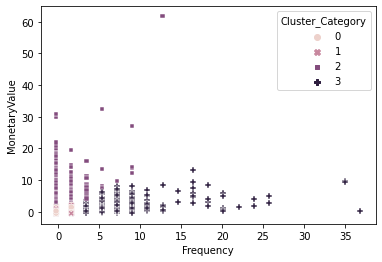

In [55]:
#lets plot Frequency vs MonetaryValue to understanding the behavior of the customer
sns.scatterplot(x='Frequency',y='MonetaryValue',data=Customer_RFM_normalized_kmeans,hue="Cluster_Category",style="Cluster_Category")

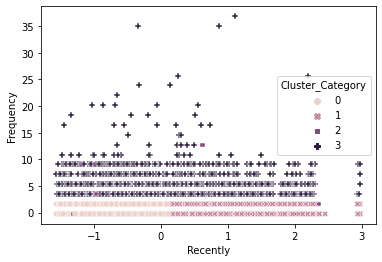

In [56]:
#lets plot recently vs frequency to understanding the behavior of the customer
sns.scatterplot(x='Recently',y='Frequency',data=Customer_RFM_normalized_kmeans,hue="Cluster_Category",style="Cluster_Category")

**AgglomerativeClustering**

**NOTE:** *not able to run entire existing dataset in colab for other clustering alogrithms due to RAM limitation(colab raising memory issues and restarting sessions).
going to try clustering on a sampled dataset.*

In [57]:
#Data Sample
sampled_df = Customer_RFM_normalized.sample(frac=0.4, replace=False, random_state=42)

In [58]:
clustering = AgglomerativeClustering().fit(sampled_df)

In [59]:
#3d plot post AgglomerativeClustering
fig = px.scatter_3d(sampled_df, x='MonetaryValue', y='Frequency', z='Recently',
              color=clustering.labels_)
fig.show()

In [60]:
#append the customer name to the normalized df
Customer_RFM_normalized_agg=sampled_df.copy()
Customer_RFM_normalized_agg.loc[:,'customer_id'] = sampled_df.index
Customer_RFM_normalized_agg['Cluster_Category'] = clustering.labels_

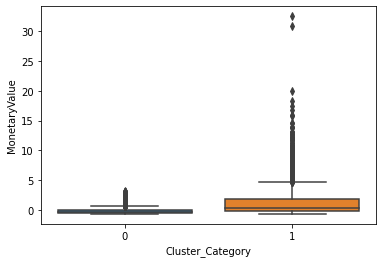

In [61]:
#plot based on Cluster_Category and MonetaryValue
sns.boxplot(x='Cluster_Category',y='MonetaryValue',data=Customer_RFM_normalized_agg)

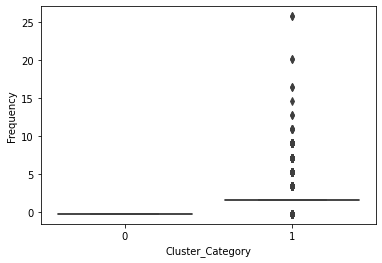

In [62]:
#plot based on Cluster_Category and Frequency
sns.boxplot(x='Cluster_Category',y='Frequency',data=Customer_RFM_normalized_agg)

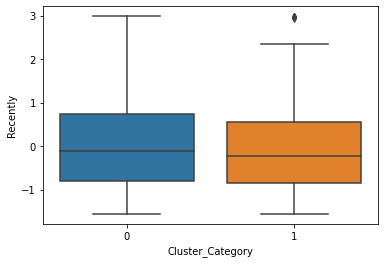

In [63]:
#plot based on Cluster_Category and Recently
sns.boxplot(x='Cluster_Category',y='Recently',data=Customer_RFM_normalized_agg)

*We are not to provide lot of analysis with other Clustering techniques due to RAM limitation in Colab.*